In [6]:
import sys, os
if '../' not in sys.path:
    sys.path.insert(0, '../')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from modules.realestate import RealEstateData
from modules.io import read_json, write_json
from modules.dynamics import *
from modules.analysis import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# LOAD ALL DATA

In [8]:
# read locations
locations = pd.read_hdf('../data/processed/locations.hdf', 'locations')
location_history = pd.read_hdf('../data/processed/locations.hdf', 'history')

# read preprocessed data (license history)
license_history = pd.read_hdf('../data/processed/licenses.hdf', 'history')
codebook = read_json('../data/processed/license_codebook.json')
activitybook = read_json('../data/processed/activity_codebook.json')

# load property values
property_values_path  = '../data/processed/realestate.hdf'
mvalfah = pd.concat(RealEstateData(property_values_path), axis=1)

# SELECT DATA

In [9]:
data = location_history.join(locations)

# COMPILE BUSINESS ADDITION/TURNOVER RATES

In [10]:
original_locations = location_history[location_history.ORIGINAL]
new_locations = location_history[~location_history.ORIGINAL]

# total number of business in each zip at beginning of dataset
original_counts = original_locations.join(locations).groupby('ZIP')['ZIP'].count()

In [11]:
# define quarterly timebins
bins = pd.date_range('10-01-2000', pd.Timestamp.today(), freq='3M')

# construct location activity timeseries
num_active_businesses = build_timeseries(spans_daterange, data, bins)
num_new_businesses = build_timeseries(starts_within_daterange, data[~data.ORIGINAL], bins)
num_closed_businesses = build_timeseries(end_within_daterange, data[~data.ACTIVE], bins)

In [12]:
# downsample to a 2 year interval (to aggregate bi-annual renewals/expirations)
freq = '2Y'
resample_mean = lambda x: x.resample(freq).mean()
resample_sum = lambda x: x.resample(freq).sum()
num_active_businesses = resample_mean(num_active_businesses)
num_new_businesses = resample_sum(num_new_businesses)
num_closed_businesses = resample_sum(num_closed_businesses)

# upsample to a 1 year interval
resample_interpolate = lambda x: x.resample('1Y').interpolate()
num_active_businesses = resample_interpolate(num_active_businesses)
num_new_businesses = resample_interpolate(num_new_businesses)/2
num_closed_businesses = resample_interpolate(num_closed_businesses)/2

In [13]:
# normalize by number of active businesses in each zip code
rate_of_addition = num_new_businesses / num_active_businesses
turnover_rate = num_closed_businesses / num_active_businesses
net_business_growth = rate_of_addition - turnover_rate

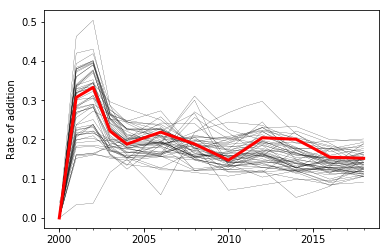

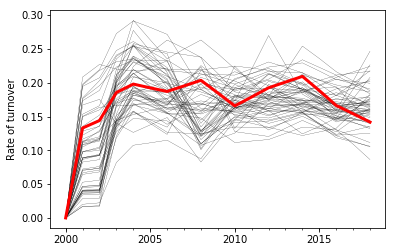

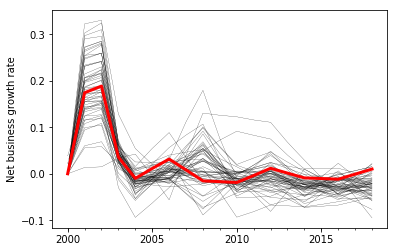

In [14]:
# plot rates of business addition, turnover, and growth
example = 60622
ax = plot_timeseries(rate_of_addition, label='Rate of addition', examples=example)
ax = plot_timeseries(turnover_rate, label='Rate of turnover', examples=example)
ax = plot_timeseries(net_business_growth, label='Net business growth rate', examples=example)

# CORRELATION WITH PROPERTY VALUES

In [15]:
# normalize and detrend realestate value data
detrended_mvalfah = detrend(normalize_by_baseline(mvalfah.resample('1Y').mean(), baseline_length=1))

# evaluate change over <nshift> years
nshift = 1
derivatives = detrended_mvalfah.diff() / nshift

# define X and Y variables for correlation analysis
X = net_business_growth[net_business_growth.index >= '2005']
Y = derivatives

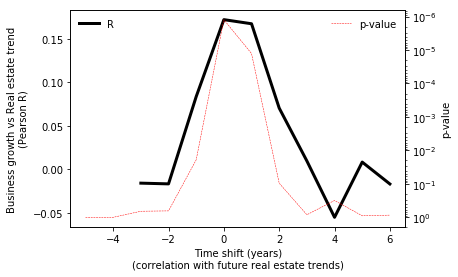

In [17]:
# evaluate global correlation with future housing market trends

offsets = np.arange(-5, 15)
coefficients, pvalues = list(zip(*[evaluate_correlation(X, Y, offset, freq) for offset in offsets]))

fig, ax = plt.subplots()
ax.set_xlabel('Time shift (years)\n(correlation with future real estate trends)')

ax.plot(offsets, coefficients, '-k', lw=3, label='R')
ax.set_ylabel('Business growth vs Real estate trend\n(Pearson R)')

ax2 = ax.twinx()
ax2.plot(offsets, pvalues, '--r', lw=0.5, label='p-value')
ax2.set_yscale('log')
ax2.invert_yaxis()
ax2.set_ylabel('p-value')
ax.legend(loc=2, frameon=False)
ax2.legend(loc=1, frameon=False)

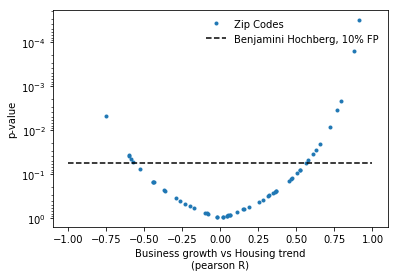

In [18]:
# evaluate correlation within each zipcode
offset = 2
results, bonf, bh = evaluate_correlation_individual(X, Y, offset)
results = results.sort_values(by='P')

# volcano plot
fig, ax = plt.subplots()
ax.plot(results.R, results.P, '.', label='Zip Codes')
ax.set_yscale('log')
ax.invert_yaxis()
#ax.plot([-1., 1.], [bonf, bonf], '--r', label='Bonferroni')
ax.plot([-1., 1.], [bh, bh], '--k', label='Benjamini Hochberg, 10% FP')
ax.set_xlabel('Business growth vs Housing trend\n(pearson R)')
ax.set_ylabel('p-value')
ax.legend(loc=1, frameon=False)

fig.savefig('individual_correlations.png')